In [1]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
from sklearn.metrics import *
from tensorflow.keras import callbacks
import seaborn as sns
import matplotlib.pyplot as plt

2023-06-26 17:22:28.397345: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def training(xtr,ytr,xval,yval,cw):
    org_model = keras.models.load_model("./model/weightmodel")
    org_model = models.Model(inputs=org_model.input, outputs=org_model.get_layer('dense_6').output) # do not include final classifier
    org_model.summary()

    org_model.trainable = False
    inputs = keras.Input(shape=(2869,1))
    x = org_model(inputs, training=False)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()
    
    earlystopping = callbacks.EarlyStopping(monitor ="val_accuracy", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

    model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
    model.fit(xtr, ytr, batch_size=10, epochs=20,validation_data=(xval, yval),
                   shuffle=True,class_weight=cw)

    org_model.trainable = True
    model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
                  loss=keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[keras.metrics.BinaryAccuracy()])

    
    model.fit(xtr, ytr, batch_size=10, epochs=50,validation_data=(xval, yval),
                   shuffle=True,class_weight=cw,callbacks =[earlystopping])
    return model

In [3]:
rna_idx=pd.read_csv("./dataBulk/common_rna.csv",index_col=0).values.squeeze().tolist()

# prepare training data
files=["26440","57065","95233","4607","8121","9692","13904","26378","28750"]

datasets = []
labels = []

for file in files:
    
    if file == "13904":
        df=pd.read_csv("./dataBulk/exp.gene.mRNA.GSE"+file+'.txt' , sep="\t").T
        df_label=pd.read_csv("./dataBulk/label_GSE"+file+'.txt' , sep="\t",header=None)
        data=df[rna_idx].T
        data=data[df_label[0]].T.values
        label=df_label[2].values>0
    else:
        df=pd.read_csv("./dataBulk/exp.gene.mRNA.GSE"+file+'.txt' , sep="\t").T
        data=df[rna_idx].values
        df_label=pd.read_csv("./dataBulk/label_GSE"+file+'.txt' , sep="\t",header=None)[2].values
        label=(df_label>0)
    
    datasets.append(data)
    labels.append(label)
datasets

[array([[ 5.686 , 11.3806,  7.1689, ..., 10.6627,  9.3806,  5.5011],
        [ 5.3899, 11.3008,  7.8225, ..., 10.7067,  9.8158,  4.895 ],
        [ 5.2863,  8.4467,  7.775 , ..., 10.7362,  7.3991,  4.7524],
        ...,
        [ 5.9418,  7.851 ,  8.5398, ...,  9.8227,  7.0775,  4.8467],
        [ 5.7863,  9.6025,  8.8713, ..., 10.5933,  7.2535,  5.5077],
        [ 5.0932,  8.5812,  7.9627, ..., 11.3954,  6.7701,  4.8525]]),
 array([[ 4.1258,  8.4825,  7.375 , ...,  9.9011,  9.977 ,  4.5518],
        [ 3.7253,  7.0136,  7.3436, ...,  9.974 , 10.9023,  4.3127],
        [ 4.1171,  7.4553,  7.5396, ...,  9.8454, 10.3504,  4.6858],
        ...,
        [ 4.6867,  8.0777,  7.48  , ...,  9.57  , 10.7467,  4.8751],
        [ 4.5665,  8.339 ,  6.8913, ...,  9.6997, 10.374 ,  4.1515],
        [ 4.4886,  7.878 ,  7.3   , ...,  9.3813, 10.6168,  4.6568]]),
 array([[ 4.6275,  7.793 ,  4.8201, ...,  9.5678, 10.3472,  4.2763],
        [ 4.3328,  6.8776,  4.857 , ..., 10.0162, 10.9576,  4.2889],
    

In [4]:
results = []
for dataset, label, training_cohort in zip(datasets,labels,files):
    xtr,xval, ytr,yval = train_test_split(dataset,label,test_size=0.2,random_state=42)

    cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(ytr),y=ytr)
    cw = {0:cw[0],1:cw[1]}
    
    model = training(xtr,ytr,xval,yval,cw)
    print("training cohort: GSE", training_cohort)
    
    test_result = []
    for x_test,y_test, test_cohort in zip(datasets,labels,files):
        testresult=model.predict(x_test)
        fpr, tpr, _ = roc_curve(y_test,testresult)
        roc_auc = auc(fpr,tpr)
        print("test cohort GSE", test_cohort, "AUC:", roc_auc)
        test_result.append(roc_auc)
        
    results.append(test_result)

2022-03-26 11:09:35.196606: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-26 11:09:35.197883: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-26 11:09:35.728773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.076GHz coreCount: 24 deviceMemorySize: 11.93GiB deviceMemoryBandwidth: 313.37GiB/s
2022-03-26 11:09:35.729140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.076GHz coreCount: 24 deviceMemorySize: 11.93GiB deviceMemoryBandwidth: 313.37GiB/s
2022-03-26 11:09:35.729172: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2869, 1)]         0         
_________________________________________________________________
weightlayer (Weightlayer)    ((None, 2869, 8), (1, 286 22952     
_________________________________________________________________
primarycap_reshape (Reshape) (None, 2869, 8)           0         
_________________________________________________________________
primarycap_squash (Lambda)   (None, 2869, 8)           0         
_________________________________________________________________
groupcaps (CapsuleLayer)     ((None, 20, 16), (None, 2 7344640   
_________________________________________________________________
transformer_block (Transform (None, 20, 16)            5392      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0     

2022-03-26 11:09:38.129910: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-26 11:09:38.130535: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3500185000 Hz


 1/11 [=>............................] - ETA: 14s - loss: 0.9612 - accuracy: 0.5000

2022-03-26 11:09:39.453481: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


11/11 [==============================] - 3s 125ms/step - loss: 1.1161 - accuracy: 0.2952 - val_loss: 1.0432 - val_accuracy: 0.1923
Epoch 2/20
11/11 [==============================] - 1s 51ms/step - loss: 0.7027 - accuracy: 0.3449 - val_loss: 0.5876 - val_accuracy: 0.8077
Epoch 3/20
11/11 [==============================] - 1s 54ms/step - loss: 0.6107 - accuracy: 0.7956 - val_loss: 0.5428 - val_accuracy: 0.8077
Epoch 4/20
11/11 [==============================] - 1s 52ms/step - loss: 0.6254 - accuracy: 0.7788 - val_loss: 0.6392 - val_accuracy: 0.9615
Epoch 5/20
11/11 [==============================] - 1s 53ms/step - loss: 0.6762 - accuracy: 0.6777 - val_loss: 0.7352 - val_accuracy: 0.1923
Epoch 6/20
11/11 [==============================] - 1s 53ms/step - loss: 0.6637 - accuracy: 0.3547 - val_loss: 0.6578 - val_accuracy: 0.7692
Epoch 7/20
11/11 [==============================] - 1s 53ms/step - loss: 0.6453 - accuracy: 0.9102 - val_loss: 0.6111 - val_accuracy: 0.9615
Epoch 8/20
11/11 [=====

Epoch 18/50
11/11 [==============================] - 2s 160ms/step - loss: 0.3721 - binary_accuracy: 0.9219 - val_loss: 0.3621 - val_binary_accuracy: 0.9615
Epoch 19/50
11/11 [==============================] - 2s 161ms/step - loss: 0.3611 - binary_accuracy: 0.9720 - val_loss: 0.3751 - val_binary_accuracy: 0.9231
Epoch 20/50
11/11 [==============================] - 2s 161ms/step - loss: 0.3376 - binary_accuracy: 0.9269 - val_loss: 0.3515 - val_binary_accuracy: 0.9231
Epoch 21/50
11/11 [==============================] - 2s 161ms/step - loss: 0.3179 - binary_accuracy: 0.9743 - val_loss: 0.2611 - val_binary_accuracy: 0.9615
Epoch 22/50
11/11 [==============================] - 2s 162ms/step - loss: 0.2989 - binary_accuracy: 0.9323 - val_loss: 0.3309 - val_binary_accuracy: 0.9231
Epoch 23/50
11/11 [==============================] - 2s 160ms/step - loss: 0.2599 - binary_accuracy: 0.9561 - val_loss: 0.2598 - val_binary_accuracy: 0.9615
Epoch 24/50
11/11 [==============================] - 2s 16

Epoch 2/50
9/9 [==============================] - 1s 156ms/step - loss: 0.6241 - binary_accuracy: 0.7410 - val_loss: 0.6095 - val_binary_accuracy: 0.9091
Epoch 3/50
9/9 [==============================] - 1s 163ms/step - loss: 0.6034 - binary_accuracy: 0.9123 - val_loss: 0.6522 - val_binary_accuracy: 0.6818
Epoch 4/50
9/9 [==============================] - 1s 163ms/step - loss: 0.5766 - binary_accuracy: 0.8724 - val_loss: 0.5849 - val_binary_accuracy: 0.9545
Epoch 5/50
9/9 [==============================] - 1s 163ms/step - loss: 0.5664 - binary_accuracy: 0.9020 - val_loss: 0.6372 - val_binary_accuracy: 0.7727
Epoch 6/50
9/9 [==============================] - 1s 163ms/step - loss: 0.6002 - binary_accuracy: 0.7452 - val_loss: 0.6335 - val_binary_accuracy: 0.7727
Epoch 7/50
9/9 [==============================] - 1s 164ms/step - loss: 0.5586 - binary_accuracy: 0.8689 - val_loss: 0.5504 - val_binary_accuracy: 1.0000
Epoch 8/50
9/9 [==============================] - 1s 163ms/step - loss: 0.56

Epoch 27/50
9/9 [==============================] - 1s 164ms/step - loss: 0.2780 - binary_accuracy: 0.9664 - val_loss: 0.2828 - val_binary_accuracy: 0.9545
Epoch 28/50
9/9 [==============================] - 1s 162ms/step - loss: 0.2369 - binary_accuracy: 0.9805 - val_loss: 0.2499 - val_binary_accuracy: 0.9545
Epoch 29/50
9/9 [==============================] - 1s 163ms/step - loss: 0.2317 - binary_accuracy: 0.9015 - val_loss: 0.2006 - val_binary_accuracy: 1.0000
Epoch 30/50
9/9 [==============================] - 1s 164ms/step - loss: 0.1898 - binary_accuracy: 0.9718 - val_loss: 0.2378 - val_binary_accuracy: 0.9091
Epoch 31/50
9/9 [==============================] - 1s 163ms/step - loss: 0.2188 - binary_accuracy: 0.9170 - val_loss: 0.1854 - val_binary_accuracy: 1.0000
Epoch 32/50
9/9 [==============================] - 1s 163ms/step - loss: 0.1763 - binary_accuracy: 1.0000 - val_loss: 0.1379 - val_binary_accuracy: 1.0000
Epoch 33/50
9/9 [==============================] - 1s 165ms/step - los

10/10 [==============================] - 2s 98ms/step - loss: 2.4453 - accuracy: 0.1662 - val_loss: 2.8165 - val_accuracy: 0.2400
Epoch 2/20
10/10 [==============================] - 1s 56ms/step - loss: 1.6126 - accuracy: 0.1919 - val_loss: 1.7003 - val_accuracy: 0.2400
Epoch 3/20
10/10 [==============================] - 1s 55ms/step - loss: 1.0629 - accuracy: 0.1424 - val_loss: 0.9245 - val_accuracy: 0.2400
Epoch 4/20
10/10 [==============================] - 1s 56ms/step - loss: 0.7679 - accuracy: 0.1907 - val_loss: 0.6760 - val_accuracy: 0.7600
Epoch 5/20
10/10 [==============================] - 1s 57ms/step - loss: 0.7862 - accuracy: 0.8170 - val_loss: 0.6421 - val_accuracy: 0.7600
Epoch 6/20
10/10 [==============================] - 1s 60ms/step - loss: 0.7004 - accuracy: 0.8557 - val_loss: 0.6676 - val_accuracy: 0.7600
Epoch 7/20
10/10 [==============================] - 1s 60ms/step - loss: 0.7828 - accuracy: 0.6760 - val_loss: 0.7254 - val_accuracy: 0.1200
Epoch 8/20
10/10 [======

Epoch 18/50
10/10 [==============================] - 2s 169ms/step - loss: 0.4901 - binary_accuracy: 0.9056 - val_loss: 0.4867 - val_binary_accuracy: 1.0000
Epoch 19/50
10/10 [==============================] - 2s 170ms/step - loss: 0.4736 - binary_accuracy: 0.9567 - val_loss: 0.4503 - val_binary_accuracy: 1.0000
Epoch 20/50
10/10 [==============================] - 2s 168ms/step - loss: 0.4898 - binary_accuracy: 0.9460 - val_loss: 0.4990 - val_binary_accuracy: 0.9600
Epoch 21/50
10/10 [==============================] - 2s 170ms/step - loss: 0.4523 - binary_accuracy: 0.8869 - val_loss: 0.4280 - val_binary_accuracy: 1.0000
Epoch 22/50
10/10 [==============================] - 2s 171ms/step - loss: 0.3667 - binary_accuracy: 0.9815 - val_loss: 0.4195 - val_binary_accuracy: 1.0000
Epoch 23/50
10/10 [==============================] - 2s 170ms/step - loss: 0.4002 - binary_accuracy: 0.9398 - val_loss: 0.4755 - val_binary_accuracy: 0.9600
Epoch 24/50
10/10 [==============================] - 2s 17

10/10 [==============================] - 3s 195ms/step - loss: 0.5469 - binary_accuracy: 0.8218 - val_loss: 0.6007 - val_binary_accuracy: 0.9200
Epoch 2/50
10/10 [==============================] - 2s 160ms/step - loss: 0.5601 - binary_accuracy: 0.8297 - val_loss: 0.6537 - val_binary_accuracy: 0.6000
Epoch 3/50
10/10 [==============================] - 2s 166ms/step - loss: 0.6353 - binary_accuracy: 0.7037 - val_loss: 0.6514 - val_binary_accuracy: 0.6000
Epoch 4/50
10/10 [==============================] - 2s 167ms/step - loss: 0.5700 - binary_accuracy: 0.7512 - val_loss: 0.5379 - val_binary_accuracy: 0.9200
Epoch 5/50
10/10 [==============================] - 2s 167ms/step - loss: 0.5329 - binary_accuracy: 0.9482 - val_loss: 0.5485 - val_binary_accuracy: 0.9200
Epoch 6/50
10/10 [==============================] - 2s 169ms/step - loss: 0.5650 - binary_accuracy: 0.8373 - val_loss: 0.6101 - val_binary_accuracy: 0.7200
Epoch 7/50
10/10 [==============================] - 2s 168ms/step - loss: 0

test cohort GSE 95233 AUC: 0.9968805704099821
test cohort GSE 4607 AUC: 0.9876543209876543
test cohort GSE 8121 AUC: 0.9911111111111112
test cohort GSE 9692 AUC: 0.9711111111111111
test cohort GSE 13904 AUC: 0.9358974358974359
test cohort GSE 26378 AUC: 0.9843205574912892
test cohort GSE 28750 AUC: 1.0
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2869, 1)]         0         
_________________________________________________________________
weightlayer (Weightlayer)    ((None, 2869, 8), (1, 286 22952     
_________________________________________________________________
primarycap_reshape (Reshape) (None, 2869, 8)           0         
_________________________________________________________________
primarycap_squash (Lambda)   (None, 2869, 8)           0         
_________________________________________________________________
groupcaps (CapsuleL

Epoch 10/50
6/6 [==============================] - 1s 177ms/step - loss: 0.0469 - binary_accuracy: 0.9776 - val_loss: 0.2973 - val_binary_accuracy: 0.8667
Epoch 11/50
6/6 [==============================] - 1s 177ms/step - loss: 0.0502 - binary_accuracy: 0.9550 - val_loss: 0.2985 - val_binary_accuracy: 0.8667
Epoch 12/50
6/6 [==============================] - 1s 174ms/step - loss: 0.0298 - binary_accuracy: 0.9952 - val_loss: 0.3119 - val_binary_accuracy: 0.8000
Epoch 13/50
6/6 [==============================] - 1s 178ms/step - loss: 0.0281 - binary_accuracy: 1.0000 - val_loss: 0.3592 - val_binary_accuracy: 0.8667
Epoch 14/50
6/6 [==============================] - 1s 174ms/step - loss: 0.0357 - binary_accuracy: 1.0000 - val_loss: 0.2993 - val_binary_accuracy: 0.8667
Epoch 15/50
6/6 [==============================] - 1s 177ms/step - loss: 0.0336 - binary_accuracy: 1.0000 - val_loss: 0.3193 - val_binary_accuracy: 0.8667
Epoch 16/50
6/6 [==============================] - 1s 178ms/step - los

Epoch 36/50
6/6 [==============================] - 1s 178ms/step - loss: 0.0120 - binary_accuracy: 1.0000 - val_loss: 0.4150 - val_binary_accuracy: 0.8667
Epoch 37/50
6/6 [==============================] - 1s 179ms/step - loss: 0.0096 - binary_accuracy: 1.0000 - val_loss: 0.4048 - val_binary_accuracy: 0.8667
Epoch 38/50
6/6 [==============================] - 1s 178ms/step - loss: 0.0078 - binary_accuracy: 1.0000 - val_loss: 0.4033 - val_binary_accuracy: 0.8667
Epoch 39/50
6/6 [==============================] - 1s 175ms/step - loss: 0.0098 - binary_accuracy: 1.0000 - val_loss: 0.4210 - val_binary_accuracy: 0.8667
Epoch 40/50
6/6 [==============================] - 1s 178ms/step - loss: 0.0061 - binary_accuracy: 1.0000 - val_loss: 0.4067 - val_binary_accuracy: 0.8667
Epoch 41/50
6/6 [==============================] - 1s 180ms/step - loss: 0.0039 - binary_accuracy: 1.0000 - val_loss: 0.4110 - val_binary_accuracy: 0.8667
Epoch 42/50
6/6 [==============================] - 1s 177ms/step - los

4/4 [==============================] - 1s 161ms/step - loss: 0.0609 - binary_accuracy: 0.9822 - val_loss: 0.0262 - val_binary_accuracy: 1.0000
Epoch 20/50
4/4 [==============================] - 1s 159ms/step - loss: 0.0581 - binary_accuracy: 0.9522 - val_loss: 0.0248 - val_binary_accuracy: 1.0000
Epoch 21/50
4/4 [==============================] - 1s 160ms/step - loss: 0.0627 - binary_accuracy: 0.9722 - val_loss: 0.0242 - val_binary_accuracy: 1.0000
Epoch 22/50
4/4 [==============================] - 1s 161ms/step - loss: 0.0562 - binary_accuracy: 0.9722 - val_loss: 0.0235 - val_binary_accuracy: 1.0000
Epoch 23/50
4/4 [==============================] - 1s 161ms/step - loss: 0.0628 - binary_accuracy: 0.9522 - val_loss: 0.0227 - val_binary_accuracy: 1.0000
Epoch 24/50
4/4 [==============================] - 1s 161ms/step - loss: 0.0379 - binary_accuracy: 0.9889 - val_loss: 0.0220 - val_binary_accuracy: 1.0000
Epoch 25/50
4/4 [==============================] - 1s 159ms/step - loss: 0.0434 - 

Epoch 45/50
4/4 [==============================] - 1s 160ms/step - loss: 0.0288 - binary_accuracy: 1.0000 - val_loss: 0.0121 - val_binary_accuracy: 1.0000
Epoch 46/50
4/4 [==============================] - 1s 161ms/step - loss: 0.0258 - binary_accuracy: 1.0000 - val_loss: 0.0119 - val_binary_accuracy: 1.0000
Epoch 47/50
4/4 [==============================] - 1s 161ms/step - loss: 0.0236 - binary_accuracy: 1.0000 - val_loss: 0.0116 - val_binary_accuracy: 1.0000
Epoch 48/50
4/4 [==============================] - 1s 159ms/step - loss: 0.0189 - binary_accuracy: 1.0000 - val_loss: 0.0114 - val_binary_accuracy: 1.0000
Epoch 49/50
4/4 [==============================] - 1s 160ms/step - loss: 0.0227 - binary_accuracy: 1.0000 - val_loss: 0.0112 - val_binary_accuracy: 1.0000
Epoch 50/50
4/4 [==============================] - 1s 159ms/step - loss: 0.0232 - binary_accuracy: 1.0000 - val_loss: 0.0109 - val_binary_accuracy: 1.0000
training cohort: GSE 9692
test cohort GSE 26440 AUC: 0.989477040816326

Epoch 3/50
6/6 [==============================] - 1s 156ms/step - loss: 0.2196 - binary_accuracy: 0.9277 - val_loss: 0.0804 - val_binary_accuracy: 1.0000
Epoch 4/50
6/6 [==============================] - 1s 158ms/step - loss: 0.2064 - binary_accuracy: 0.9150 - val_loss: 0.0739 - val_binary_accuracy: 1.0000
Epoch 5/50
6/6 [==============================] - 1s 160ms/step - loss: 0.1785 - binary_accuracy: 0.9273 - val_loss: 0.0657 - val_binary_accuracy: 1.0000
Epoch 6/50
6/6 [==============================] - 1s 162ms/step - loss: 0.1903 - binary_accuracy: 0.9297 - val_loss: 0.0589 - val_binary_accuracy: 1.0000
Epoch 7/50
6/6 [==============================] - 1s 164ms/step - loss: 0.1446 - binary_accuracy: 0.9671 - val_loss: 0.0528 - val_binary_accuracy: 1.0000
Epoch 8/50
6/6 [==============================] - 1s 162ms/step - loss: 0.1602 - binary_accuracy: 0.9345 - val_loss: 0.0488 - val_binary_accuracy: 1.0000
Epoch 9/50
6/6 [==============================] - 1s 162ms/step - loss: 0.12

Epoch 29/50
6/6 [==============================] - 1s 163ms/step - loss: 0.0701 - binary_accuracy: 0.9805 - val_loss: 0.0201 - val_binary_accuracy: 1.0000
Epoch 30/50
6/6 [==============================] - 1s 163ms/step - loss: 0.0615 - binary_accuracy: 0.9805 - val_loss: 0.0195 - val_binary_accuracy: 1.0000
Epoch 31/50
6/6 [==============================] - 1s 164ms/step - loss: 0.0701 - binary_accuracy: 0.9686 - val_loss: 0.0190 - val_binary_accuracy: 1.0000
Epoch 32/50
6/6 [==============================] - 1s 162ms/step - loss: 0.0841 - binary_accuracy: 0.9507 - val_loss: 0.0184 - val_binary_accuracy: 1.0000
Epoch 33/50
6/6 [==============================] - 1s 163ms/step - loss: 0.0555 - binary_accuracy: 0.9834 - val_loss: 0.0175 - val_binary_accuracy: 1.0000
Epoch 34/50
6/6 [==============================] - 1s 164ms/step - loss: 0.0609 - binary_accuracy: 0.9686 - val_loss: 0.0177 - val_binary_accuracy: 1.0000
Epoch 35/50
6/6 [==============================] - 1s 162ms/step - los

9/9 [==============================] - 2s 99ms/step - loss: 0.6039 - accuracy: 0.8762 - val_loss: 0.5865 - val_accuracy: 0.8571
Epoch 2/20
9/9 [==============================] - 0s 54ms/step - loss: 0.6013 - accuracy: 0.8437 - val_loss: 0.6996 - val_accuracy: 0.3333
Epoch 3/20
9/9 [==============================] - 0s 54ms/step - loss: 0.6684 - accuracy: 0.2613 - val_loss: 0.6763 - val_accuracy: 0.6667
Epoch 4/20
9/9 [==============================] - 0s 53ms/step - loss: 0.6394 - accuracy: 0.6226 - val_loss: 0.5829 - val_accuracy: 0.8095
Epoch 5/20
9/9 [==============================] - 0s 53ms/step - loss: 0.6357 - accuracy: 0.8230 - val_loss: 0.5688 - val_accuracy: 0.8571
Epoch 6/20
9/9 [==============================] - 0s 53ms/step - loss: 0.6957 - accuracy: 0.8152 - val_loss: 0.6367 - val_accuracy: 0.8571
Epoch 7/20
9/9 [==============================] - 0s 55ms/step - loss: 0.6789 - accuracy: 0.7013 - val_loss: 0.6281 - val_accuracy: 0.9048
Epoch 8/20
9/9 [======================

Epoch 18/50
9/9 [==============================] - 1s 157ms/step - loss: 0.5003 - binary_accuracy: 0.8730 - val_loss: 0.4691 - val_binary_accuracy: 0.9048
Epoch 19/50
9/9 [==============================] - 1s 155ms/step - loss: 0.4943 - binary_accuracy: 0.7522 - val_loss: 0.4490 - val_binary_accuracy: 0.9524
Epoch 20/50
9/9 [==============================] - 1s 158ms/step - loss: 0.4694 - binary_accuracy: 0.9069 - val_loss: 0.4015 - val_binary_accuracy: 0.9524
Epoch 21/50
9/9 [==============================] - 1s 156ms/step - loss: 0.4579 - binary_accuracy: 0.9030 - val_loss: 0.4097 - val_binary_accuracy: 0.9524
Epoch 22/50
9/9 [==============================] - 1s 158ms/step - loss: 0.4792 - binary_accuracy: 0.8859 - val_loss: 0.4130 - val_binary_accuracy: 0.9524
Epoch 23/50
9/9 [==============================] - 1s 156ms/step - loss: 0.5162 - binary_accuracy: 0.8613 - val_loss: 0.3841 - val_binary_accuracy: 0.9524
Epoch 24/50
9/9 [==============================] - 1s 158ms/step - los

Epoch 44/50
9/9 [==============================] - 1s 157ms/step - loss: 0.2414 - binary_accuracy: 0.9322 - val_loss: 0.1426 - val_binary_accuracy: 1.0000
Epoch 45/50
9/9 [==============================] - 1s 158ms/step - loss: 0.2036 - binary_accuracy: 0.9470 - val_loss: 0.1630 - val_binary_accuracy: 0.9524
Epoch 46/50
9/9 [==============================] - 1s 158ms/step - loss: 0.1911 - binary_accuracy: 0.9314 - val_loss: 0.1236 - val_binary_accuracy: 1.0000
Epoch 47/50
9/9 [==============================] - 1s 158ms/step - loss: 0.2006 - binary_accuracy: 0.9590 - val_loss: 0.1142 - val_binary_accuracy: 1.0000
Epoch 48/50
9/9 [==============================] - 1s 159ms/step - loss: 0.1826 - binary_accuracy: 0.9640 - val_loss: 0.1080 - val_binary_accuracy: 1.0000
Epoch 49/50
9/9 [==============================] - 1s 156ms/step - loss: 0.2278 - binary_accuracy: 0.9687 - val_loss: 0.1431 - val_binary_accuracy: 0.9524
Epoch 50/50
9/9 [==============================] - 1s 158ms/step - los

Epoch 2/50
3/3 [==============================] - 1s 485ms/step - loss: 0.6541 - binary_accuracy: 0.7750 - val_loss: 0.6629 - val_binary_accuracy: 0.6667
Epoch 3/50
3/3 [==============================] - 0s 125ms/step - loss: 0.6915 - binary_accuracy: 0.6750 - val_loss: 0.6672 - val_binary_accuracy: 0.6667
Epoch 4/50
3/3 [==============================] - 1s 464ms/step - loss: 0.6358 - binary_accuracy: 0.7750 - val_loss: 0.6651 - val_binary_accuracy: 0.6667
Epoch 5/50
3/3 [==============================] - 0s 128ms/step - loss: 0.6284 - binary_accuracy: 0.8542 - val_loss: 0.6746 - val_binary_accuracy: 0.6667
Epoch 6/50
3/3 [==============================] - 1s 476ms/step - loss: 0.6933 - binary_accuracy: 0.9000 - val_loss: 0.6830 - val_binary_accuracy: 0.5000
Epoch 7/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6441 - binary_accuracy: 0.8833 - val_loss: 0.6728 - val_binary_accuracy: 0.6667
Epoch 8/50
3/3 [==============================] - 0s 129ms/step - loss: 0.62

Epoch 28/50
3/3 [==============================] - 0s 145ms/step - loss: 0.5901 - binary_accuracy: 0.9000 - val_loss: 0.5960 - val_binary_accuracy: 0.6667
Epoch 29/50
3/3 [==============================] - 0s 144ms/step - loss: 0.5724 - binary_accuracy: 0.9000 - val_loss: 0.5906 - val_binary_accuracy: 0.6667
Epoch 30/50
3/3 [==============================] - 0s 148ms/step - loss: 0.5864 - binary_accuracy: 0.8750 - val_loss: 0.5893 - val_binary_accuracy: 0.6667
Epoch 31/50
3/3 [==============================] - 0s 145ms/step - loss: 0.6013 - binary_accuracy: 0.8500 - val_loss: 0.5908 - val_binary_accuracy: 0.6667
Epoch 32/50
3/3 [==============================] - 0s 143ms/step - loss: 0.5612 - binary_accuracy: 0.9000 - val_loss: 0.5928 - val_binary_accuracy: 0.6667
Epoch 33/50
3/3 [==============================] - 0s 141ms/step - loss: 0.5657 - binary_accuracy: 0.9083 - val_loss: 0.6010 - val_binary_accuracy: 0.8333
Epoch 34/50
3/3 [==============================] - 0s 143ms/step - los

In [6]:
cohort_name = ['GSE' + name for name in files]
df_results = pd.DataFrame(results, index = cohort_name, columns = cohort_name)
df_results

,GSE26440,GSE57065,GSE95233,GSE4607,GSE8121,GSE9692,GSE13904,GSE26378,GSE28750
GSE26440,0.998406,1.000000,0.998217,0.986420,0.981111,0.997778,0.961538,0.992451,1.000
GSE57065,0.999362,1.000000,1.000000,0.989506,0.908889,0.902222,0.858974,0.998258,1.000
GSE95233,0.994898,0.999512,1.000000,0.987037,0.917778,0.966667,0.920940,0.997677,1.000
GSE4607,0.997130,0.998049,0.996881,0.987654,0.991111,0.971111,0.935897,0.984321,1.000
GSE8121,0.825574,0.947805,0.977718,0.831173,0.992222,0.982222,0.973291,0.878049,0.840
GSE9692,0.989477,0.989268,0.995098,0.976543,0.985556,1.000000,0.977564,0.958769,1.000
GSE13904,0.975128,0.968780,0.974153,0.969753,0.985556,1.000000,1.000000,0.926829,0.965
GSE26378,0.998406,1.000000,1.000000,0.988272,0.932222,0.966667,0.840812,1.000000,1.000
GSE28750,0.997768,0.999512,0.998663,0.983333,0.860000,0.906667,0.821581,0.990708,1.000


#  Plot

In [2]:
df__ = pd.read_csv('./figures/data/rotatingTest.csv',index_col=0)
df__

,GSE26440,GSE57065,GSE95233,GSE4607,GSE8121,GSE9692,GSE13904,GSE26378,GSE28750
GSE26440,0.998406,1.000000,0.998217,0.986420,0.981111,0.997778,0.961538,0.992451,1.000
GSE57065,0.999362,1.000000,1.000000,0.989506,0.908889,0.902222,0.858974,0.998258,1.000
GSE95233,0.994898,0.999512,1.000000,0.987037,0.917778,0.966667,0.920940,0.997677,1.000
GSE4607,0.997130,0.998049,0.996881,0.987654,0.991111,0.971111,0.935897,0.984321,1.000
GSE8121,0.825574,0.947805,0.977718,0.831173,0.992222,0.982222,0.973291,0.878049,0.840
GSE9692,0.989477,0.989268,0.995098,0.976543,0.985556,1.000000,0.977564,0.958769,1.000
GSE13904,0.975128,0.968780,0.974153,0.969753,0.985556,1.000000,1.000000,0.926829,0.965
GSE26378,0.998406,1.000000,1.000000,0.988272,0.932222,0.966667,0.840812,1.000000,1.000
GSE28750,0.997768,0.999512,0.998663,0.983333,0.860000,0.906667,0.821581,0.990708,1.000


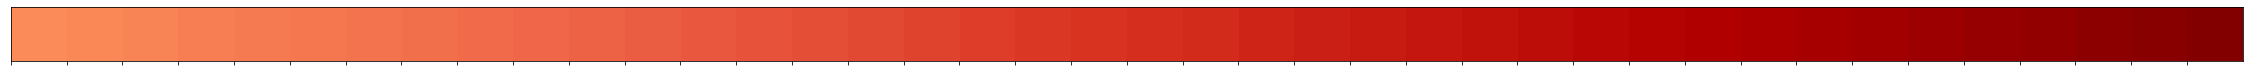

In [2]:
# sns.palplot(sns.color_palette("OrRd_r", 20)) 
new_c=sns.color_palette("OrRd", 80)[40:80]
sns.palplot(new_c)

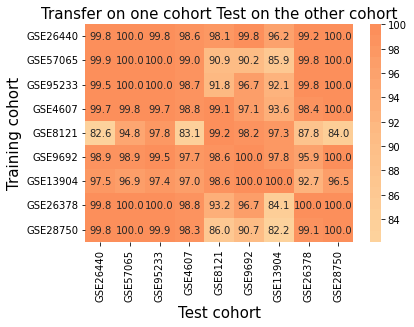

In [93]:
hm_plot = sns.heatmap(df__*100, annot=True, fmt=".1f", cmap=new_c)
hm_plot.set_xlabel('Test cohort', fontsize=15)
hm_plot.set_ylabel('Training cohort', fontsize=15)
hm_plot.set_title('Transfer on one cohort Test on the other cohort', fontsize = 15)
fig = hm_plot.get_figure()
fig.savefig('./figures/rotate_test.png', bbox_inches='tight',dpi=600)

<AxesSubplot:>

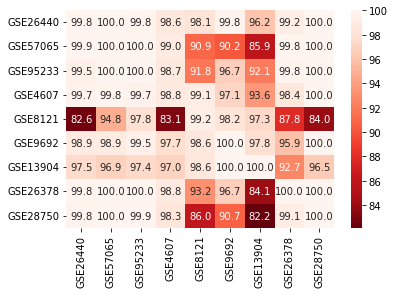

In [73]:
sns.heatmap(df__*100, annot=True, fmt=".1f", cmap="Reds_r")